# 6-Cluster Geofencing

In this notebook we use the results from the previous one to display the geographic clusters on a map, using the H3 package.

**Requirements:**

- Please run the `5-clustering-hdbscan.ipynb` notebook first and its dependencies.
- Recommended install: [ipywidgets](https://ipywidgets.readthedocs.io/en/stable/user_install.html). Enable using `jupyter nbextension enable --py widgetsnbextension --sys-prefix` for Jupyter Notebook and `jupyter labextension install @jupyter-widgets/jupyterlab-manager` for Jupyter Lab.

In [42]:
import numpy as np
import folium
import ipywidgets as widgets
import networkx as nx

from folium.vector_layers import PolyLine
from sqlapi import VedDb
from h3 import h3
from shapely.geometry import Polygon
from shapely.ops import cascaded_union
from ipywidgets import interact
from tqdm.auto import tqdm

Create an object of the `VedDB` type to interface with the database.

In [2]:
db = VedDb()

To illustrate the process of retrieval of an endpoint's hexagons, let's run a simple query to return all the H3 codes for cluster number 23.

In [3]:
def get_cluster_hexes(cluster_id):
    sql = "select h3 from cluster_point where cluster_id = ?"
    hexes = list({h[0] for h in db.query(sql, [cluster_id])})
    return hexes

In [4]:
hexes = get_cluster_hexes(23)
hexes

['8c2ab259ba643ff',
 '8c2ab259bb4a9ff',
 '8c2ab259ba649ff',
 '8c2ab259bb487ff',
 '8c2ab259bb497ff',
 '8c2ab259ba601ff',
 '8c2ab259ba651ff',
 '8c2ab259ba65bff',
 '8c2ab259ba645ff',
 '8c2ab259bb4b5ff',
 '8c2ab259bb4bbff',
 '8c2ab259ba655ff',
 '8c2ab25996969ff',
 '8c2ab259bb4b9ff',
 '8c2ab259bb4a3ff',
 '8c2ab259bb495ff',
 '8c2ab259ba657ff',
 '8c2ab259ba647ff',
 '8c2ab259ba629ff',
 '8c2ab259ba65dff',
 '8c2ab259bb485ff',
 '8c2ab259bb481ff',
 '8c2ab259ba659ff',
 '8c2ab259bb4b3ff',
 '8c2ab259bb4abff',
 '8c2ab25996967ff',
 '8c2ab2599696dff',
 '8c2ab259bb4a1ff',
 '8c2ab259ba64bff',
 '8c2ab259ba60dff',
 '8c2ab25996965ff',
 '8c2ab259bb4a7ff',
 '8c2ab259ba60bff',
 '8c2ab259ba609ff',
 '8c2ab259ba605ff',
 '8c2ab259ba663ff',
 '8c2ab259ba653ff',
 '8c2ab259bb4b7ff',
 '8c2ab259ba66bff',
 '8c2ab259ba661ff',
 '8c2ab25996961ff',
 '8c2ab259ba667ff',
 '8c2ab259ba641ff',
 '8c2ab259bb4bdff',
 '8c2ab259bb4b1ff']

The code above uses a Python `set` comprehension in order to retrieve the unique H3 codes. As you probably guessed, it is very likely to find overlapping H3 hexagons in the same cluster, and using a `set` eliminates repetitions.

To convert an H3 code into a map object, we must first expand it into a set of six geo locations using the `h3_to_geo_boundary` function.

In [5]:
h = hexes[0]

The `get_hexagon` converts an H3 index into the corresponding hexagon vertices' geographic coordinates. Note how we copy the first coordinate to the back of the list in order to _close_ the polygon.

In [6]:
def get_hexagon(h):
    geo_lst = [p for p in h3.h3_to_geo_boundary(h)]
    geo_lst.append(geo_lst[0])
    return np.array(geo_lst)

Let's see how the function works.

In [7]:
hexagon = get_hexagon(h)
hexagon

array([[ 42.23077143, -83.6804412 ],
       [ 42.23073858, -83.68056938],
       [ 42.23064348, -83.68059101],
       [ 42.23058122, -83.68048445],
       [ 42.23061406, -83.68035627],
       [ 42.23070917, -83.68033465],
       [ 42.23077143, -83.6804412 ]])

## Display the Hexagon on the Map

To display the hexagon on a map, we use code that is similar to the one we used in notebook number 4 to display a trip.

Let's start by declaring the map object.

In [8]:
map = folium.Map(prefer_canvas=True, tiles="cartodbpositron")

Determine the shape's bounding box and fit the map view to it.

In [9]:
min_lat, max_lat = hexagon[:, 0].min(), hexagon[:, 0].max()
min_lon, max_lon = hexagon[:, 1].min(), hexagon[:, 1].max()
map.fit_bounds([[min_lat, min_lon], [max_lat, max_lon]])

Now, we create a `PolyLine` object and place it on the map.

In [10]:
color = '#3388ff'
opacity = 0.7
polyline = PolyLine(hexagon, color=color, opacity=opacity, fill=color)
p = polyline.add_to(map)

In [11]:
map

## Display the Cluster on the Map

We can now extend the code to the whole cluster and display all the hexagons side-by side.

In [12]:
html_map = folium.Map(prefer_canvas=True, tiles="cartodbpositron")

bb_list = []  # List for the bounding-box calculation

for h in hexes:
    hexagon = get_hexagon(h)
    bb_list.extend(hexagon.tolist())
    polyline = PolyLine(hexagon, color=color, opacity=opacity, fill=color)
    p = polyline.add_to(map)
    
locations = np.array(bb_list)
min_lat, max_lat = locations[:, 0].min(), locations[:, 0].max()
min_lon, max_lon = locations[:, 1].min(), locations[:, 1].max()
html_map.fit_bounds([[min_lat, min_lon], [max_lat, max_lon]])
html_map

But we can still do better: how about only displaying the cluster outline? We can do so by merging all the hexagons together using Shapely's `Polygon` object and the `cascaded_union` function. The idea is to model each hexagon as a `Polygon` and then merge them into a single map polygon.

In [13]:
def create_map_polygon(xy, tooltip='',
                       color='#3388ff',
                       opacity=0.7,
                       fill_color='#3388ff',
                       fill_opacity=0.4, 
                       weight=3):
    points = [[x[0], x[1]] for x in xy]
    polygon = folium.vector_layers.Polygon(locations=points,
                                           tooltip=tooltip,
                                           fill=True,
                                           color=color,
                                           fill_color=fill_color,
                                           fill_opacity=fill_opacity,
                                           weight=weight,
                                           opacity=opacity)
    return polygon

Start by creating the map with the whitewashed tiles.

In [14]:
html_map = folium.Map(prefer_canvas=True, tiles="cartodbpositron")

Now, generate the H3 hexagons and convert them into Shapely `Polygon`s.

In [15]:
bb_list = []  # List for the bounding-box calculation
polygons = []
for h in hexes:
    points = get_hexagon(h)
    xy = [[x[1], x[0]] for x in points]
    xy.append([points[0][1], points[0][0]])
    polygons.append(Polygon(xy))
    bb_list.extend(points)

With a single call to `cascaded_union`, we merge all the `Polygon` objects into a single one that we can conveniently plot on the map. Note that by converting all hexagons into a single polygon, we are not only making the display cleaner, but we are also reducing the amount of redundant points used to define the shape. If you decide to store the shape on a database, this will prove extremely useful.

In [16]:
merged = cascaded_union(polygons)

The polygon merge operation may have created a complex polygonal shape with "holes". To gracefully handle this situation, we must check if the generated object is a simple `Polygon` or a `MultiPolygon`. The former case is simple to handle, but for the latter we simply use the largest one.

In [17]:
if merged.geom_type == "MultiPolygon":
    max_len = 0
    largest = None
    for geom in merged.geoms:
        xy = geom.exterior.coords.xy
        lxy = list(zip(xy[1], xy[0]))

#         if len(lxy) > max_len:
#             max_len = len(lxy)
#             largest = lxy

        create_map_polygon(lxy).add_to(html_map)
elif merged.geom_type == "Polygon":
    xy = merged.exterior.coords.xy
    lxy = list(zip(xy[1], xy[0]))

    create_map_polygon(lxy).add_to(html_map)

We can now fit the shape boundaries to the map and display it.

In [18]:
locations = np.array(bb_list)
min_lat, max_lat = locations[:, 0].min(), locations[:, 0].max()
min_lon, max_lon = locations[:, 1].min(), locations[:, 1].max()
html_map.fit_bounds([[min_lat, min_lon], [max_lat, max_lon]])
html_map

If you hover the mouse cursor over the shape you will see an empty tooltip. This feature would be interesting to use should we be able to automatically name these clusters, using real street name information. This is the challenge for the next notebook.

Meanwhile, let's check the quality of the generated polygons.

## Interactive Cluster Exploration


In [19]:
def show_geofence_map(cluster_id):
    html_map = folium.Map(prefer_canvas=True, tiles="cartodbpositron")
    bb_list = []  # List for the bounding-box calculation
    polygons = []
    hexes = get_cluster_hexes(cluster_id)
    for h in hexes:
        points = get_hexagon(h)
        xy = [[x[1], x[0]] for x in points]
        xy.append([points[0][1], points[0][0]])
        polygons.append(Polygon(xy))
        bb_list.extend(points)
        
    merged = cascaded_union(polygons)
    
    if merged.geom_type == "MultiPolygon":
        max_len = 0
        largest = None
        for geom in merged.geoms:
            xy = geom.exterior.coords.xy
            lxy = list(zip(xy[1], xy[0]))
            create_map_polygon(lxy).add_to(html_map)
    elif merged.geom_type == "Polygon":
        xy = merged.exterior.coords.xy
        lxy = list(zip(xy[1], xy[0]))

        create_map_polygon(lxy).add_to(html_map)
        
    locations = np.array(bb_list)
    min_lat, max_lat = locations[:, 0].min(), locations[:, 0].max()
    min_lon, max_lon = locations[:, 1].min(), locations[:, 1].max()
    html_map.fit_bounds([[min_lat, min_lon], [max_lat, max_lon]])
    return html_map

In [20]:
sql = "select count(distinct cluster_id) from cluster_point"
cluster_count = db.query_scalar(sql)

In [21]:
cluster_count

290

In [22]:
ii = interact(show_geofence_map, cluster_id=widgets.IntSlider(min=0, max=cluster_count-1, step=1, value=0))

interactive(children=(IntSlider(value=0, description='cluster_id', max=289), Output()), _dom_classes=('widget-…

It seems that not all clusters are represented by a single shape, and it is not a rare thing. What went wrong here?

By selecting a fixed size for the H3 hexagons, we are actually enabling that these gaps show up when a particular set of points strays farther than the hexagon's size. How can we solve this issue? We can either increase the size of the hexagons, or we can be a bit smarter and build _bridges_ between the _islands_. But for that, we need the help from graph theory.

## Clusters as Networks

The idea is to analyze a specific cluster and determine if all the hexagons are neighbors. A network is useful here to determine if there are isolated hexagons. First we create a network using `networkx` and feed it with all the hexagon codes as nodes. Next, for each pair of neighboring hexagons, we declare an edge on the network. Once this is done, we can compute the _connected components_ and use that as a means to connect them back.

The function `graph_from_hexes` accepts a list od H3 indexes and build a graph of their neighboring status.

In [23]:
def graph_from_hexes(hexes):
    g = nx.Graph()
    for i in range(len(hexes)):
        g.add_node(hexes[i])
        for j in range(i+1, len(hexes)):
            if h3.h3_indexes_are_neighbors(hexes[i], hexes[j]):
                g.add_edge(hexes[i], hexes[j])
    return g

Now, let's build and display the graph for cluster `0`.

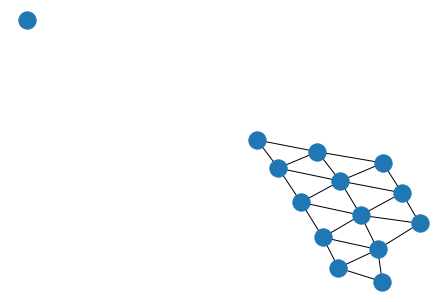

In [24]:
hexes = get_cluster_hexes(0)
g = graph_from_hexes(hexes)
nx.draw(g)

We can now query how many connected components there are and which ones are they.

In [25]:
nx.number_connected_components(g)

2

In [30]:
components = list(nx.connected_components(g))
components

[{'8c274994c85a3ff',
  '8c274994c85a7ff',
  '8c274994c85b1ff',
  '8c274994c85b3ff',
  '8c274994c85b5ff',
  '8c274994c85b7ff',
  '8c274994c85bdff',
  '8c274994cbb49ff',
  '8c274994cbb4bff',
  '8c274994cbb51ff',
  '8c274994cbb59ff',
  '8c274994cbb5bff',
  '8c274994cbb5dff'},
 {'8c274994cbb45ff'}]

To make our lives easier, `networkx` reports the connected components as a list of sets. But now we need to build the _bridge_ between the components, and we will use H3 for that. The idea is to use the `h3_line` function and enumerate all possible ways we have to connect the hexagons between the two components. We will keep the smallest line that should, in the best scenarios, have only 3 hexagons, and which is actually a very good early stopping criterion. Note that in some circumstances we might need more hexagons to bridge the gap.

Let's see how the function works:

In [29]:
h3.h3_line('8c274994c85a3ff', '8c274994cbb45ff')

['8c274994c85a3ff', '8c274994cbb49ff', '8c274994cbb4dff', '8c274994cbb45ff']

Here's the draft of the algorithm below.

In [31]:
bridges = []
for h0 in components[0]:
    for h1 in components[1]:
        bridge = h3.h3_line(h0, h1)
        bridges.append(bridge)

We can now inspect the list of possible bridges and there three candidates. Take your pick!

In [32]:
bridges

[['8c274994c85b5ff', '8c274994cbb49ff', '8c274994cbb41ff', '8c274994cbb45ff'],
 ['8c274994cbb49ff', '8c274994cbb41ff', '8c274994cbb45ff'],
 ['8c274994c85bdff',
  '8c274994c85b5ff',
  '8c274994cbb49ff',
  '8c274994cbb41ff',
  '8c274994cbb45ff'],
 ['8c274994c85a7ff', '8c274994cbb4dff', '8c274994cbb45ff'],
 ['8c274994c85b7ff', '8c274994cbb4bff', '8c274994cbb41ff', '8c274994cbb45ff'],
 ['8c274994cbb5dff', '8c274994cbb43ff', '8c274994cbb41ff', '8c274994cbb45ff'],
 ['8c274994cbb51ff',
  '8c274994cbb55ff',
  '8c274994cbb43ff',
  '8c274994cbb47ff',
  '8c274994cbb45ff'],
 ['8c274994c85b3ff',
  '8c274994c85b7ff',
  '8c274994cbb4bff',
  '8c274994cbb41ff',
  '8c274994cbb45ff'],
 ['8c274994cbb59ff',
  '8c274994cbb5dff',
  '8c274994cbb43ff',
  '8c274994cbb41ff',
  '8c274994cbb45ff'],
 ['8c274994cbb4bff', '8c274994cbb41ff', '8c274994cbb45ff'],
 ['8c274994c85a3ff', '8c274994cbb49ff', '8c274994cbb4dff', '8c274994cbb45ff'],
 ['8c274994c85b1ff',
  '8c274994c85b5ff',
  '8c274994cbb4bff',
  '8c274994cbb41f

We can ask Python to do the work automatically for us:

In [34]:
min(bridges, key=lambda v: len(v))

['8c274994cbb49ff', '8c274994cbb41ff', '8c274994cbb45ff']

As you can see, both the first and last elements of the list already belong to the connected components. To patch up the cluster geofence, we just need the middle H3 index, and add it to the cluster.

Below, we automate the process for all clusters by adding the missing hexagons to the clusters, not forgetting to store them in the database.

In [40]:
def get_bridge(components):
    bridges = []
    for h0 in components[0]:
        for h1 in components[1]:
            bridge = h3.h3_line(h0, h1)
            
            if len(bridge) == 3:
                # This is a good solution for sure
                return bridge
            bridges.append(bridge)
    return min(bridges, key=lambda v: len(v))

In [44]:
for cluster_id in tqdm(range(cluster_count)):
    hexes = get_cluster_hexes(cluster_id)
    g = graph_from_hexes(hexes)
    
    while nx.number_connected_components(g) > 1:
        components = list(nx.connected_components(g))
        bridge = get_bridge(components)
        
        pts = []
        for h in bridge[1:-1]:
            lat_lon = h3.h3_to_geo(h)
            hexes.append(h)
            pts.append((cluster_id, lat_lon[0], lat_lon[1], h))
            
        db.insert_cluster_points(pts)
        
        # Rebuild the graph
        g = graph_from_hexes(hexes)

You can now go back to the interactive map and explore the patched geofences.

In the next notebook we will try to give sensible names to these babies...